In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# 1. Đọc dữ liệu và parse cột date
train = pd.read_csv('/content/train.csv', parse_dates=["date"])
valid = pd.read_csv('/content/validation.csv', parse_dates=["date"])
test = pd.read_csv('/content/test.csv', parse_dates=["date"])

In [3]:
# 2. Gộp toàn bộ dữ liệu để phân tích
df_all = pd.concat([train, valid, test], ignore_index=True)

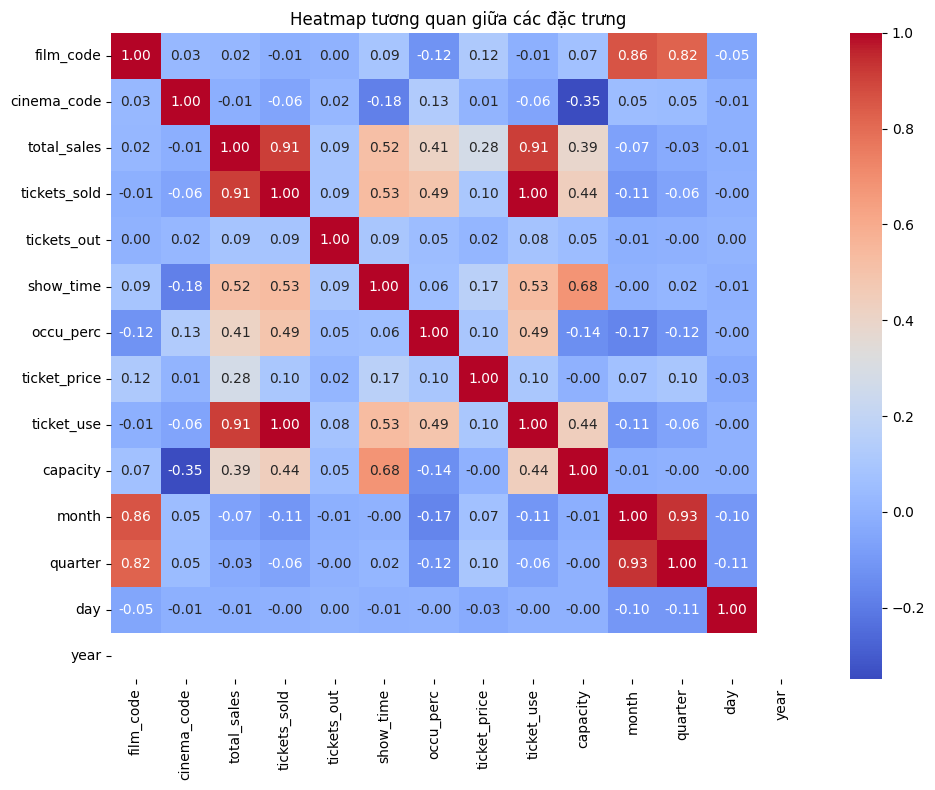

In [4]:
# 3. Vẽ heatmap tương quan
corr_matrix = df_all.select_dtypes(include='number').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap tương quan giữa các đặc trưng")
plt.tight_layout()
plt.show()

In [5]:
# # 4. Chọn các đặc trưng có tương quan cao với total_sales
# target_corr = corr_matrix['total_sales'].drop('total_sales')
# relevant_features = target_corr[abs(target_corr) >= 0.3].sort_values(ascending=False)
# selected_features = relevant_features.index.tolist()

# # Thêm các đặc trưng thời gian
# time_features = ['month', 'quarter', 'day', 'year']
# for feature in time_features:
#     if feature not in selected_features:
#         selected_features.append(feature)

In [6]:
# print("Các đặc trưng được chọn:")
# print(selected_features)

In [7]:
# 5. Chuẩn hóa dữ liệu và tạo chuỗi thời gian
sequence_length = 30
features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

train_valid = pd.concat([train, valid], ignore_index=True)
df_model = pd.concat([train_valid, test], ignore_index=True)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df_model[features])
y_scaled = scaler_y.fit_transform(df_model[[target]])

In [8]:
# 6. Chỉ tạo sequence trên toàn bộ dữ liệu (để forecast tiếp từ cuối test)
def create_sequences(x, y, seq_len):
    xs, ys = [], []
    for i in range(seq_len, len(x)):
        xs.append(x[i-seq_len:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

X_all, y_all = create_sequences(X_scaled, y_scaled, sequence_length)

In [9]:
# 7. Dùng train + valid để train mô hình (loại bỏ phần test)
train_valid_len = len(train_valid)
X_train = X_all[:train_valid_len - sequence_length]
y_train = y_all[:train_valid_len - sequence_length]

In [22]:
# 8. Xây dựng mô hình LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs = 30,
    batch_size = 32,
    verbose = 1,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0011
Epoch 2/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 6.7703e-04
Epoch 3/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 6.4300e-04
Epoch 4/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 6.9755e-04
Epoch 5/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 5.9761e-04
Epoch 6/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 7.3742e-04
Epoch 7/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.6840e-04
Epoch 8/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7.2550e-04
Epoch 9/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 5.8902e-04
Epoch 10/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 7.4667e-04
Epoch 11/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 6.3659e-04
Epoch 12/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 6.1184e-04
Epoch 13/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 6.1065e-04
Epoch 14/30
1343/1343 ━━━━━━━━━━━━━━━━

In [23]:
# Đánh giá
# Dự đoán trên tập test để đánh giá
X_test_eval = X_all[train_valid_len - sequence_length : len(df_model) - sequence_length]
y_test_eval = y_all[train_valid_len - sequence_length : len(df_model) - sequence_length]

y_pred = model.predict(X_test_eval)
y_pred_real = scaler_y.inverse_transform(y_pred)
y_test_real = scaler_y.inverse_transform(y_test_eval)

# Tính các chỉ số đánh giá
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 11165168.499360405
RMSE: 27205922.63076544
R² Score: 0.24268711135957555


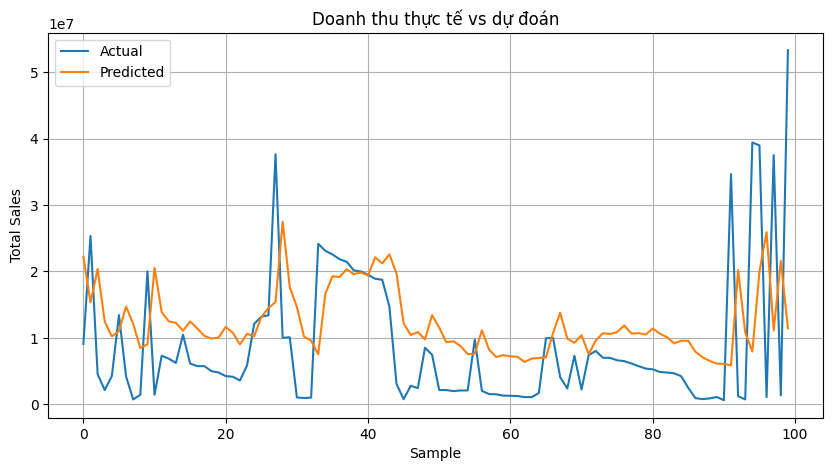

In [24]:
# 6. Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_real[:100], label='Actual')
plt.plot(y_pred_real[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [25]:
# 10. Dự đoán 30 ngày tiếp theo từ điểm cuối của test
last_sequence_input = X_scaled[-sequence_length:].reshape(1, sequence_length, len(features))
future_preds = []

for _ in range(30):
    next_pred = model.predict(last_sequence_input, verbose=0)[0][0]
    future_preds.append(next_pred)
    last_sequence_input = np.append(last_sequence_input[:,1:,:], [[X_scaled[-1]]], axis=1)

future_preds_real = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))
last_date = df_model['date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

In [29]:
# Tạo DataFrame chứa dự đoán
future_preds_real_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_preds_real.flatten(),
    'type': 'Forecasted Sales'})
print(future_preds_real_df)

         date  total_sales              type
0  2018-12-11   28563520.0  Forecasted Sales
1  2018-12-12   33134368.0  Forecasted Sales
2  2018-12-13   34250376.0  Forecasted Sales
3  2018-12-14   35283060.0  Forecasted Sales
4  2018-12-15   35913648.0  Forecasted Sales
5  2018-12-16   36377876.0  Forecasted Sales
6  2018-12-17   36778040.0  Forecasted Sales
7  2018-12-18   37169032.0  Forecasted Sales
8  2018-12-19   37512088.0  Forecasted Sales
9  2018-12-20   37840632.0  Forecasted Sales
10 2018-12-21   38153500.0  Forecasted Sales
11 2018-12-22   38421216.0  Forecasted Sales
12 2018-12-23   38634044.0  Forecasted Sales
13 2018-12-24   38825096.0  Forecasted Sales
14 2018-12-25   39005316.0  Forecasted Sales
15 2018-12-26   39178556.0  Forecasted Sales
16 2018-12-27   39380684.0  Forecasted Sales
17 2018-12-28   39557716.0  Forecasted Sales
18 2018-12-29   39710460.0  Forecasted Sales
19 2018-12-30   39858160.0  Forecasted Sales
20 2018-12-31   39991144.0  Forecasted Sales
21 2019-01

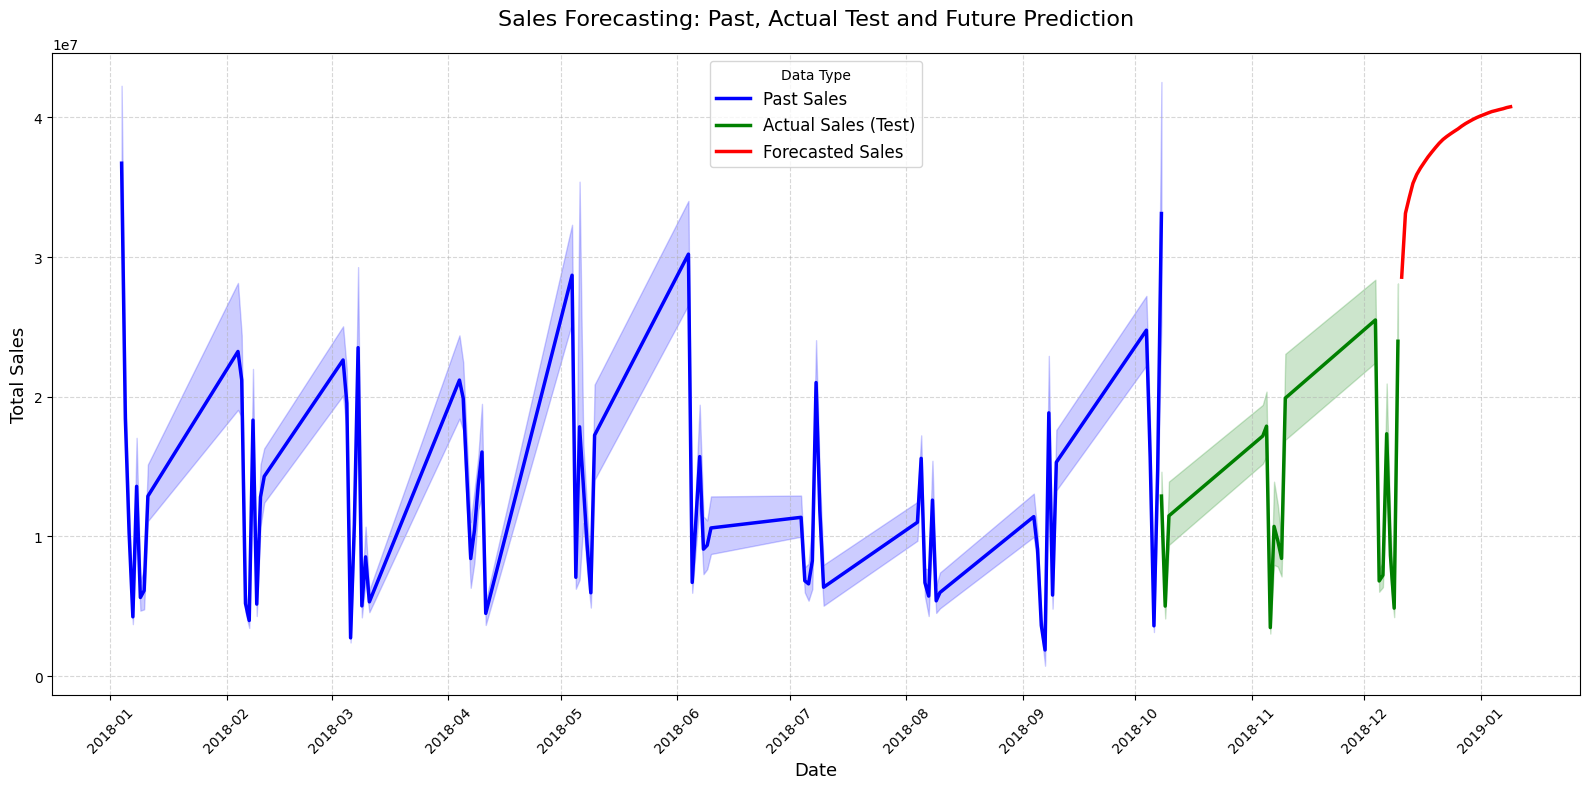

In [30]:
# 11. Vẽ biểu đồ
# Chuẩn bị dữ liệu quá khứ để visualization
train['type'] = 'Past Sales'
valid['type'] = 'Past Sales'
test['type'] = 'Actual Sales (Test)'  # Thêm thông tin cho test data

# Gộp tất cả dữ liệu
combined_df = pd.concat([
    train[['date', 'total_sales', 'type']],
    valid[['date', 'total_sales', 'type']],
    test[['date', 'total_sales', 'type']],
    future_preds_real_df
], ignore_index=True)

# Vẽ đồ thị
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

# Định dạng trục x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Thêm các chi tiết cho đồ thị
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting: Past, Actual Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()